In [1]:
# Standard library imports
import os
import random

# Related third-party imports
import numpy as np
import torch
from PIL import Image
import torchvision.transforms as transforms
from torchvision.transforms import functional as TF

# Seed setting for reproducibility
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
import sys

sys.path.append(os.path.abspath('..'))
from utils.utils_constants import (CLASSIFICATION_SEVERITY_MAPPING, 
                                   VESSEL_NEPTUNE_PAT_INFO_PATH as VESSEL_PAT_INFO_PATH, 
                                   CLASSIFICATION_PATH, SEGMENTATION_DIR, 
                                   TRI_CASE_DIR, CROPPED_VESSELS_DIR)

from utils.utils_data import Config



In [2]:
import torch
from torch.utils.data import Dataset
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
from PIL import Image
import numpy as np
import os
import random

import matplotlib.pyplot as plt

def rgb_to_mask(rgb_image):
    # Define the mapping from RGB colors to class labels
    color_to_label = {
        (255, 0, 0): 1,   # Outer contour in red
        (0, 255, 0): 2,   # Middle contours in green
        (0, 0, 255): 3,   # Inner contours in blue
        (128, 0, 128): 4, # Hyalinosis contours in purple
        (0, 0, 0): 0      # Background
    }
    label_mask = np.zeros((rgb_image.shape[0], rgb_image.shape[1]), dtype=np.uint8)
    for color, label in color_to_label.items():
        # Create a mask for each color matching
        matches = np.all(rgb_image == np.array(color, dtype=np.uint8), axis=-1)
        label_mask[matches] = label
    return label_mask

class VesselDataset(Dataset):
    def __init__(self, img_path_list, mask_suffix, transform=None, target_transform=None, transform_seed=0):
        self.img_path_list = img_path_list
        self.mask_suffix = mask_suffix
        self.transform = transform
        self.target_transform = target_transform
        self.transform_seed = transform_seed

    def __getitem__(self, idx):
        # Load images and masks
        img_path = self.img_path_list[idx]
        target_path = img_path.replace("_ori.png", self.mask_suffix)
        img = Image.open(img_path).convert("RGB")
        img = np.array(img)

        target = Image.open(target_path).convert("RGB")
        w_ori, h_ori = target.size

        # Convert RGB mask to categorical labels
        target = np.array(target)
        target = rgb_to_mask(target)
        
        if self.transform is not None:
            torch.manual_seed(self.transform_seed)
            img = self.transform(img)
        if self.target_transform is not None:
            torch.manual_seed(self.transform_seed)
            target = self.target_transform(target)
        return img_path, img, target, w_ori, h_ori

    def __len__(self):
        return len(self.imgs)

2024-07-01 00:08:38,198 - INFO - Configuration loaded from configs/config_five_classes.json


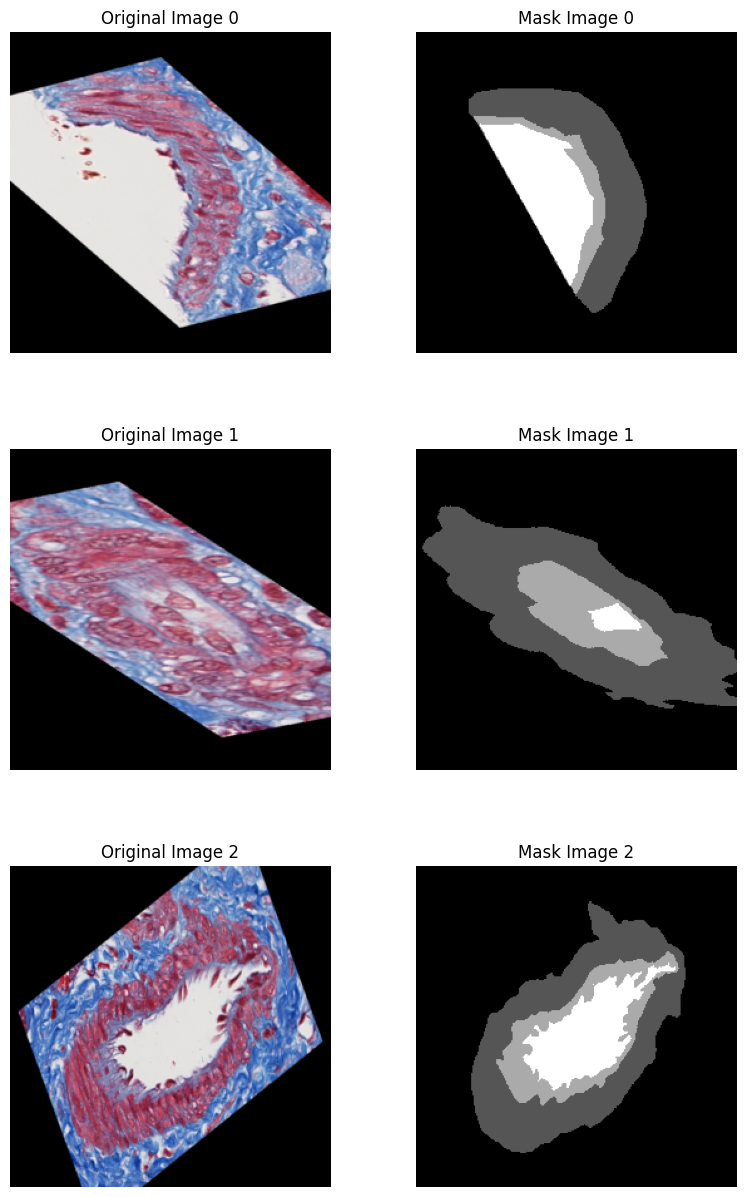

In [6]:


img_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomVerticalFlip(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(30, translate=None, scale=(0.7,1.3), shear=20),
    # transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.Resize((256, 256)),  # Specify desired height and width
    transforms.ToTensor(),
    ])

mask_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomVerticalFlip(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(30, translate=None, scale=(0.7,1.3), shear=20),
    transforms.Resize((256, 256)),  # Specify desired height and width
    lambda x: np.array(x, dtype=np.int32),  # Convert PIL Image to a NumPy array, maintaining integer labels
    transforms.ToTensor(),
    # lambda x: torch.squeeze(x, 0).long()  # Remove channel dimension and convert to long dtype
    ])

# Load configuration
config_path = "configs/config_five_classes.json"
if not os.path.exists(config_path):
    raise FileNotFoundError(f"Configuration file not found: {config_path}")
config = Config(config_path)
device = torch.device(f'cuda:{config.get("training.gpu_id")}' if torch.cuda.is_available() else 'cpu')

# Create an instance of the dataset
dataset = VesselDataset(img_path_list = config.get("data.train_files"), mask_suffix="_mask.png",
                        transform = img_transform, target_transform= mask_transform)

# Function to convert a tensor to a numpy array for visualization
def tensor_to_numpy(tensor):
    return tensor.permute(1, 2, 0).numpy()

# Set up matplotlib figures
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(10, 15))
fig.subplots_adjust(hspace=0.3, wspace=0.1)

for i in range(3):
    # Get data from dataset
    _, img, mask, _, _ = dataset[i]  # Get the i-th sample
    # Convert tensors to numpy arrays for visualization
    img = tensor_to_numpy(img)
    mask = tensor_to_numpy(mask)

    # Plotting
    axs[i, 0].imshow(img)
    axs[i, 0].set_title(f'Original Image {i}')
    axs[i, 0].axis('off')

    axs[i, 1].imshow(mask, cmap='gray')
    axs[i, 1].set_title(f'Mask Image {i}')
    axs[i, 1].axis('off')
plt.show()